# Assignment objective

In this assignment you will apply several tactics in order to detect potential risks in a population of borrowers. This tactics would be used in order to determine whether the deployment of the flyer program in Raleigh, NC, may have had the adverse effect of increasing activation disproportionally more for riskier borrowers.

# General remark 

Throughout the assignment, you are encouraged to use certain packages for various objectives. These are only recommendations, feel free to use a different package if you feel more comfortable with it or write your own code. Everything goes, as long as the output is correct!

# Basic imports


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot_2samples
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.mixture import GaussianMixture
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Data preparation

Start by reading the processed activation tables from Raleigh and Lubbock. These are available on the assignment's `s3` path, which can be imported from `pagayapro.data_paths.data_paths.ASSIGNMENT2_DATA`. 

In [26]:
from pagayapro.paths.data_paths import ASSIGNMENT2_DATA

In [27]:
raleigh_df = pd.read_csv(os.path.join(ASSIGNMENT2_DATA,"raleigh_final_activation_table.csv"))

In [28]:
lubbock_df = pd.read_csv(os.path.join(ASSIGNMENT2_DATA,"lubbock_final_activation_table.csv"))

Disply the first 5 rows of each table. How many rows are there in each table?

In [29]:
raleigh_df.head()

,id,sequence_num,requested_amount,offered_interest_rate,offer_accepted,offer_date
0,94fe9530622e8302e12906e7a65f58d1e164bc0d05f514...,90e4b7a2dc13cb20f06723807c7a4bba4da57875ff2e51...,2500.0,11.97,False,2020-10-23
1,423a4e06ace6d70156cb1d3f6f8c2e327788cf00df43f5...,31ec3034b1c29c120fad2776bec57c21d42a4b1b0e6cf5...,3500.0,24.37,False,2019-07-12
2,ae1e5ef03b7ea096d65d46ffc334273a3234fc0e414a4c...,9707b1364bcd918a919db139c3d7402c85aee1eb3dfb9d...,3026.0,30.32,False,2018-08-24
3,3fc1e327a430b8895508e697c901f5da85eee7f5db19f3...,509c8db99695731191f5c2fc20b4e664d7aa108530ba65...,3000.0,12.94,True,2019-09-16
4,96a39f00dc2322233b9e080114030898ada13a904ccc29...,2ba1b1a11ec63ca7d0f8cc0cd5527d591dfea6716f54b2...,5000.0,16.89,False,2019-11-12


In [30]:
lubbock_df.head()

,id,sequence_num,requested_amount,offered_interest_rate,offer_accepted,offer_date
0,55ede7a145fc312ed7206bfde6b1597f995a9e7cdf42e6...,3464754c8bef531e7e90f0d83cd4df04ea2d7e24ba75cd...,5300.0,32.05,False,2020-04-24
1,c3a63cef599c03c7af1258fb58bf2164ae2b57699ece7e...,ed16849cf72e00d9f0593604ce7dc5c754435d1c696f2b...,14000.0,15.26,False,2019-04-29
2,1f91c6b7b97c43ad691241faf61fb6634ed298eb7de8f9...,e8ff4579419d35c833ac8d5dc726ba44a04a054a82e203...,10500.0,5.49,False,2020-04-29
3,7d4cae1e2bba10256b5f115cd797cf1d255d4aacab9d17...,8efa42707a799ef939ec9b7f2f6220e6e5f9aefdb306af...,19500.0,11.10,True,2020-08-04
4,f5aa5c275def34cc3e6b533d41a8b706558babe30f35e2...,90cd5ac4b02cc83a48b924795e2fdf87e60ebbdf63065c...,30000.0,11.61,True,2018-05-04


In [31]:
print(raleigh_df.info(), lubbock_df.info())
print(raleigh_df.shape[0], lubbock_df.shape[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8792 entries, 0 to 8791
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     8792 non-null   object 
 1   sequence_num           8792 non-null   object 
 2   requested_amount       8792 non-null   float64
 3   offered_interest_rate  8792 non-null   float64
 4   offer_accepted         8792 non-null   bool   
 5   offer_date             8792 non-null   object 
dtypes: bool(1), float64(2), object(3)
memory usage: 352.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11320 entries, 0 to 11319
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     11320 non-null  object 
 1   sequence_num           11320 non-null  object 
 2   requested_amount       11320 non-null  float64
 3   offered_interest_rate  11320 non-null  flo

In order to analyze borrowers in Raleigh and Lubbock, we would like to enriched these tables with features from TU. These features are available (as in the previous assignment) in the file `tu_gen_data_2018Q3.parquet` in the path in `pagayapro.paths.data_paths.DATA_FILES_PATH`.

In [32]:
from pagayapro.paths.data_paths import DATA_FILES_PATH
tu_2018Q3= pd.read_parquet(os.path.join(DATA_FILES_PATH,"tu_gen_data_2018Q3.parquet"))
tu_data = tu_2018Q3[["credit_score", # creadit score
    "int_rate", # interest rate
    "loan_amnt", # loan amount
    "listing_term", # months
    "monthly_pmt", # monthly payments
    "is_unsecured", # unsecured user
    "pti", # payment / incume
    "dti", # debdt / incume
    "zip", # zip code
    "sequence_num", # ID
    "cosignr1", # cosigner
    "bcpmtstr"]] # platform name

In [33]:
tu_data.head()

,credit_score,int_rate,loan_amnt,listing_term,monthly_pmt,is_unsecured,pti,dti,zip,sequence_num,cosignr1,bcpmtstr
id,,,,,,,,,,,,
adf5219e4cb985352184eb7fa597737e4a9777f7354f7a8a58270da147792561,814,7.86,5500.0,36.0,172.0,True,NaN,NaN,32503,d0820401b209782dae4284b3dd96b41e08c3e8566fbb33...,I,TRANSACTOR
0a0f130443af4c6597bb074942970eaddeb125d398e2cca42175c56befc8a171,800,7.91,20000.0,36.0,626.0,True,NaN,NaN,10706,2f05cd66cb998e5e55f6f296344b271b2b89b996c7c037...,,TRANSACTOR
4ba9c6a38b650ee06b8b88a48621bd363cdf611e63400c6fc4bbffbd1bf20c47,653,30.51,3674.0,36.0,157.0,True,NaN,NaN,70128,20bdbfaf0006db032d8a4176add08fd4ef45abfb17c474...,I,TRANSACTOR
dae3a344292e07d4b8935a453c37aef01303f21b2f37ccbd1c4408f158533acb,623,23.46,14056.0,60.0,400.0,True,NaN,NaN,98032,53084498c6bf053a4d1cf309e1b8ec234e503bb1a3dd4e...,I,REVOLVER
8af2ae2462d012e4d85aa687a16a4f5fb64525928235da43c795f73dc0cadd04,627,25.55,8659.0,60.0,257.0,True,NaN,NaN,17013,f750c4ecac12ae1c156998ed3dff3f46d2d19f37250074...,I,REVOLVER


Merge the activation tables from Raleigh and Lubbock with TU's features

In [34]:
raleigh_table = raleigh_df.merge(tu_data, how = 'left', on = ['id', 'sequence_num'])
lubbock_table = lubbock_df.merge(tu_data, how = 'left', on = ['id', 'sequence_num'])

Make sure that the merge operation did not change the number of rows in either of the tables

In [35]:
print(raleigh_table.shape[0], lubbock_table.shape[0])

8792 11320


In [36]:
raleigh_table.head()

,id,sequence_num,requested_amount,offered_interest_rate,offer_accepted,offer_date,credit_score,int_rate,loan_amnt,listing_term,monthly_pmt,is_unsecured,pti,dti,zip,cosignr1,bcpmtstr
0,94fe9530622e8302e12906e7a65f58d1e164bc0d05f514...,90e4b7a2dc13cb20f06723807c7a4bba4da57875ff2e51...,2500.0,11.97,False,2020-10-23,776,11.97,2500.0,36.0,83.0,True,NaN,NaN,56449,I,REVOLVER
1,423a4e06ace6d70156cb1d3f6f8c2e327788cf00df43f5...,31ec3034b1c29c120fad2776bec57c21d42a4b1b0e6cf5...,3500.0,24.37,False,2019-07-12,647,24.37,3500.0,36.0,138.0,True,NaN,NaN,54301,C,RVLRPLUS
2,ae1e5ef03b7ea096d65d46ffc334273a3234fc0e414a4c...,9707b1364bcd918a919db139c3d7402c85aee1eb3dfb9d...,3026.0,30.32,False,2018-08-24,603,30.32,3026.0,36.0,129.0,True,NaN,NaN,96761,I,REVOLVER
3,3fc1e327a430b8895508e697c901f5da85eee7f5db19f3...,509c8db99695731191f5c2fc20b4e664d7aa108530ba65...,3000.0,12.94,True,2019-09-16,711,12.94,3000.0,36.0,101.0,True,NaN,NaN,92395,I,REVOLVER
4,96a39f00dc2322233b9e080114030898ada13a904ccc29...,2ba1b1a11ec63ca7d0f8cc0cd5527d591dfea6716f54b2...,5000.0,16.89,False,2019-11-12,637,16.89,5000.0,36.0,178.0,True,NaN,NaN,24141,,REVOLVER


# EDA 

To begin with, let's make sure that the general borrower population in Raleigh and Lubbock are similar. To do so, consider the features `credit_score`, `int_rate` and pick one-two more continuous features that seem important to you (look for ones whose name is meaningful). Compare the distributions of these features in Raleigh and in Lubbock by creating overlapping histograms. Make sure that your histograms are in `density=True` mode and that they are distributed over the same bins; otherwise, comparing them might be difficult.

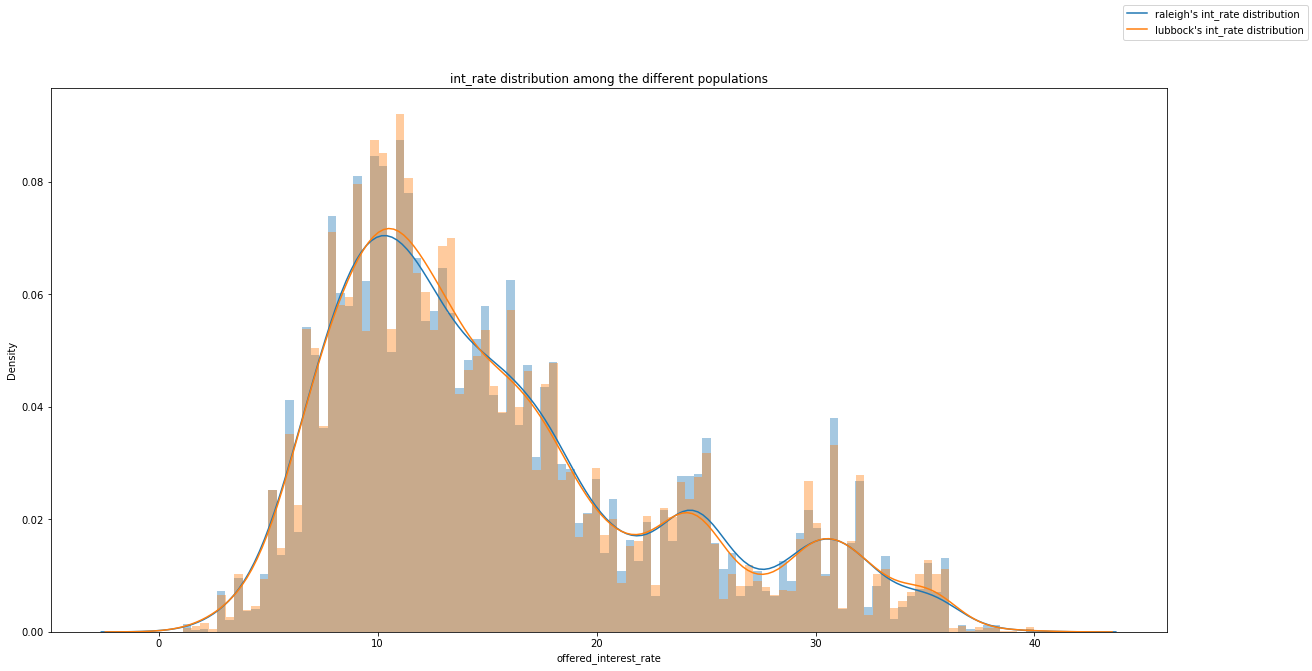

In [37]:
fig = plt.figure(figsize=(20,10))

sns.distplot(raleigh_table.offered_interest_rate, bins = 100)
sns.distplot(lubbock_table.offered_interest_rate, bins = 100)

fig.legend(labels=["raleigh's int_rate distribution","lubbock's int_rate distribution"])
plt.title("int_rate distribution among the different populations")
plt.show();

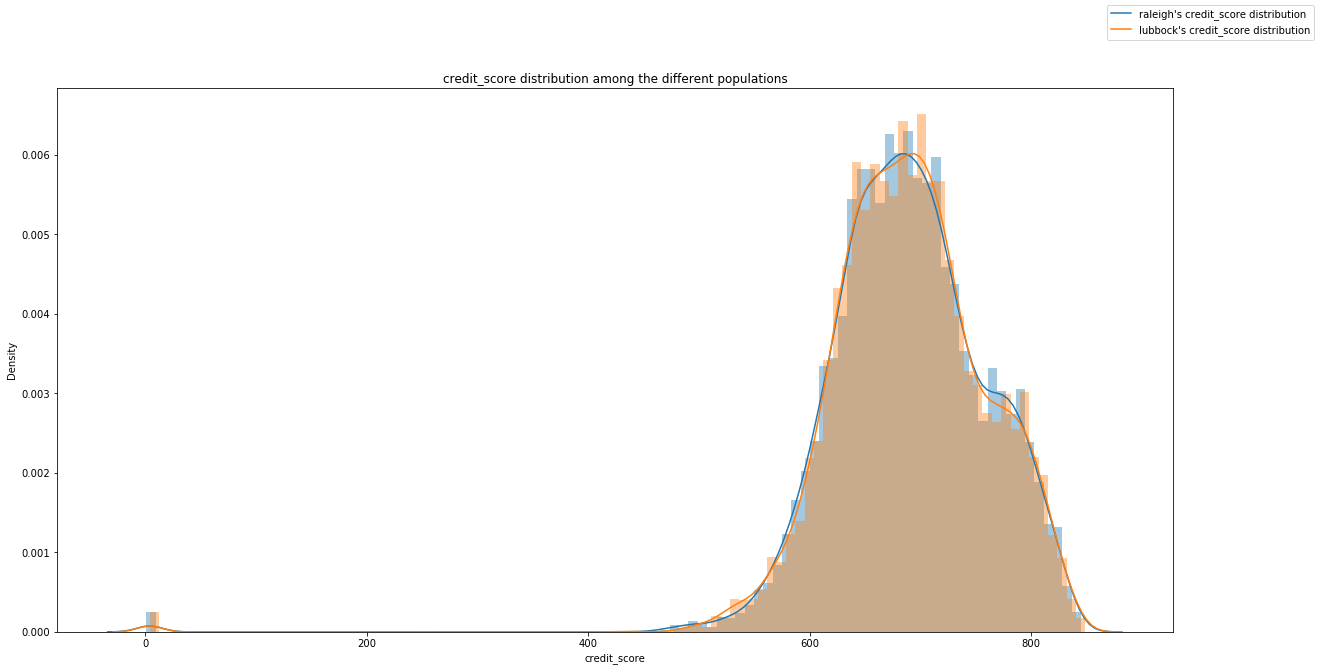

In [38]:
fig = plt.figure(figsize=(20,10))

sns.distplot(raleigh_table.credit_score, bins = 100)
sns.distplot(lubbock_table.credit_score, bins = 100)

fig.legend(labels=["raleigh's credit_score distribution","lubbock's credit_score distribution"])
plt.title("credit_score distribution among the different populations")
plt.show();

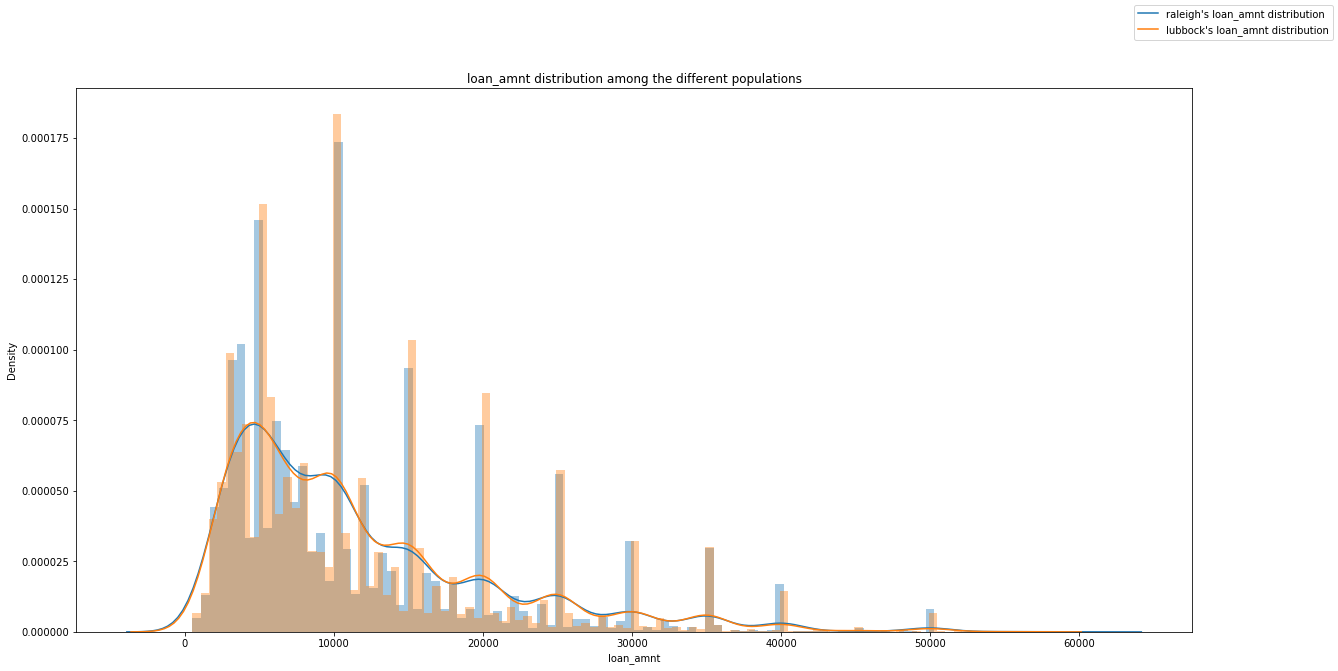

In [39]:
fig = plt.figure(figsize=(20,10))

sns.distplot(raleigh_table.loan_amnt[raleigh_table.loan_amnt<60000], bins = 100)
sns.distplot(lubbock_table.loan_amnt[lubbock_table.loan_amnt<60000], bins = 100)

fig.legend(labels=["raleigh's loan_amnt distribution","lubbock's loan_amnt distribution"])
plt.title("loan_amnt distribution among the different populations")
plt.show();

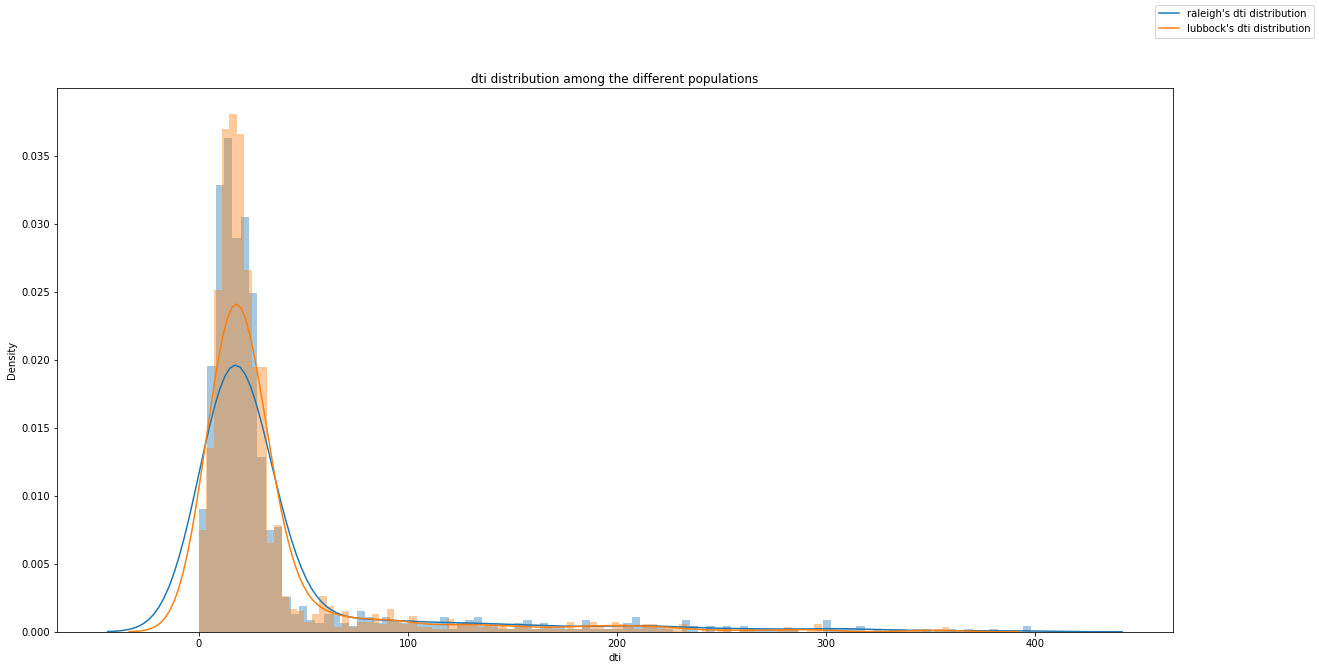

In [40]:
fig = plt.figure(figsize=(20,10))

sns.distplot(raleigh_table.dti[raleigh_table.dti<400], bins = 100)
sns.distplot(lubbock_table.dti[lubbock_table.dti<400], bins = 100)

fig.legend(labels=["raleigh's dti distribution","lubbock's dti distribution"])
plt.title("dti distribution among the different populations")
plt.show();

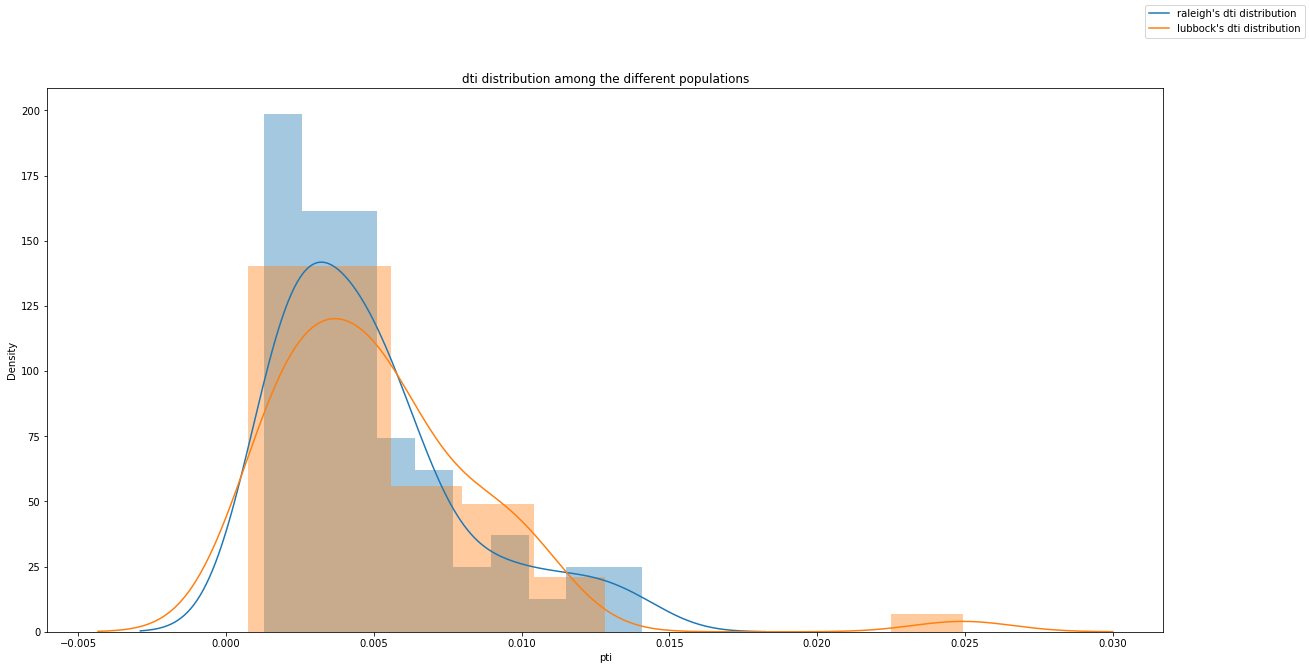

In [41]:
fig = plt.figure(figsize=(20,10))

sns.distplot(raleigh_table.pti[raleigh_table.dti<5], bins = 10)
sns.distplot(lubbock_table.pti[lubbock_table.dti<5], bins = 10)

fig.legend(labels=["raleigh's dti distribution","lubbock's dti distribution"])
plt.title("dti distribution among the different populations")
plt.show();

As you probably noticed, some borrowers have credit score values of 0. This can't be true, because credit score ranges from 350 to 850. Fix this by replacing these values with np.nan. Recreate the histograms after doing so, to make sure that they distributions still look the same.

In [42]:
raleigh_table.loc[raleigh_table.credit_score<350, 'credit_score'] = np.nan
lubbock_table.loc[lubbock_table.credit_score<350, 'credit_score'] = np.nan

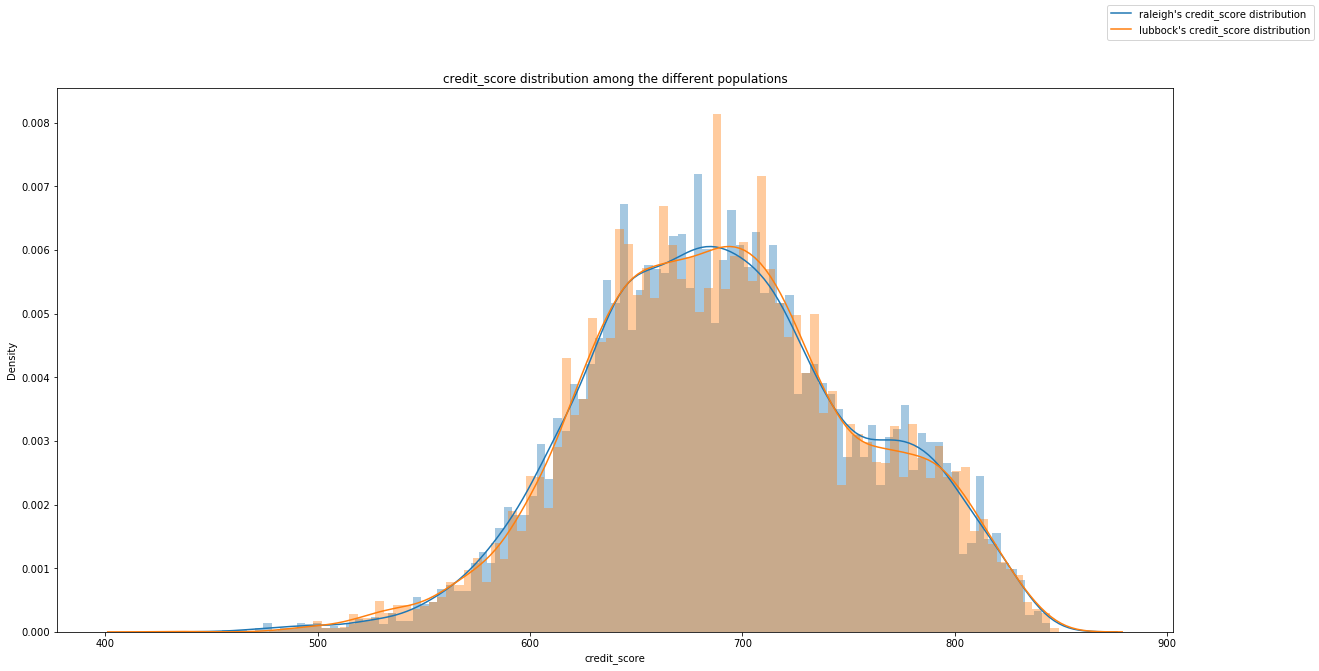

In [43]:
fig = plt.figure(figsize=(20,10))

sns.distplot(raleigh_table.credit_score, bins = 100)
sns.distplot(lubbock_table.credit_score, bins = 100)

fig.legend(labels=["raleigh's credit_score distribution","lubbock's credit_score distribution"])
plt.title("credit_score distribution among the different populations")
plt.show();

Another method for comparing the distributions of two columns is by using a [q-q-plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot). Repeat the comparisons of the above 5 features by creating the corresponding q-q-plots. You can either use the `seaborn_qqplot` package or [statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.graphics.gofplots.qqplot_2samples.html)'s implemetation, or write your own function that creates this plot. 

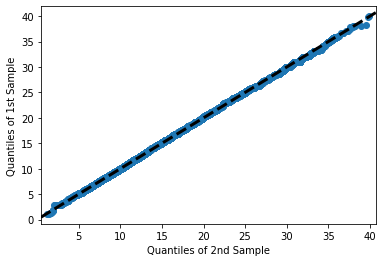

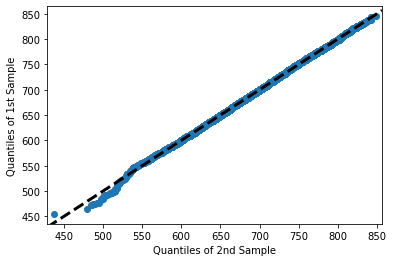

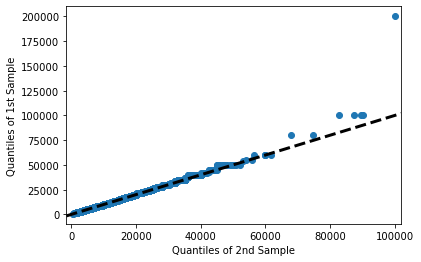

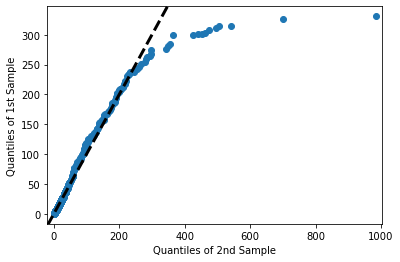

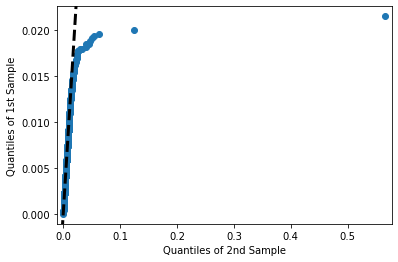

In [44]:
for col in ["offered_interest_rate", "credit_score", "loan_amnt", "dti", "pti"]:
    qqplot_2samples(raleigh_table[col], lubbock_table[col])
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    plt.show()

<span style="color:teal">It seems that, other than some outliers (very high or very low numbers) the distributions are similar.</span>

This method is also commonly used for visually comparing an observed distribution with a theoretical one (e.g. checking whether the values of a given column are normally distributed). One implementation is the [statsmodels.graphics.gofplots.qqplot](https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.qqplot.html) package which allows you to compare a given array with various distributions. 

Use this package to compare the distribution of credit score and interest rate in both town with a normal distribution.

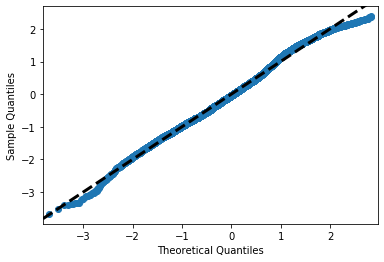

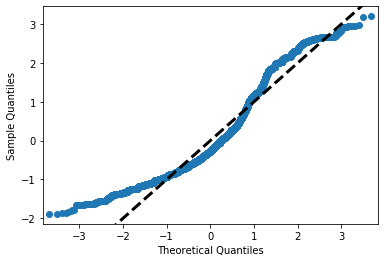

In [45]:
# fig = sm.qqplot(raleigh_table.credit_score, stats.norm)#, distargs=(4,), loc=3, scale=10)
# plt.show()
# fig = sm.qqplot(raleigh_table.offered_interest_rate, stats.norm)#, distargs=(4,), loc=3, scale=10)
# plt.show()

m = raleigh_table.credit_score.mean()
sd = raleigh_table.credit_score.std()
fig = sm.qqplot((raleigh_table.credit_score-m)/sd, stats.norm)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.show()
m = raleigh_table.offered_interest_rate.mean()
sd = raleigh_table.offered_interest_rate.std()
fig = sm.qqplot((raleigh_table.offered_interest_rate-m)/sd, stats.norm)#, distargs=(4,), loc=3, scale=10)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.show()


<span style="color:teal"> Both distributions seem to have a bad fit with a normal distribution, but credit score seems less bad</span>

## Comparing activated populations 

Redo the above comparisons only for borrowes in Raleigh and Lubbock which accepted their loan offers

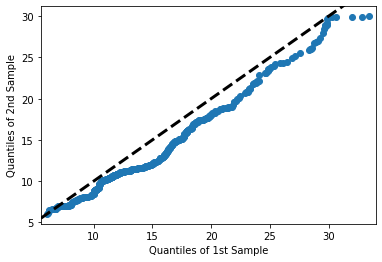

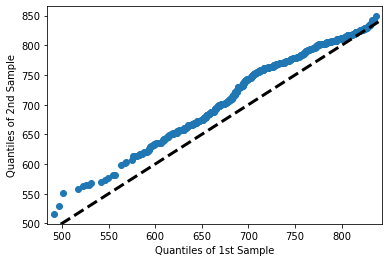

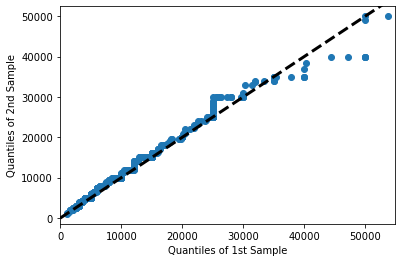

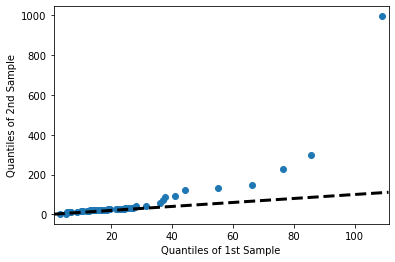

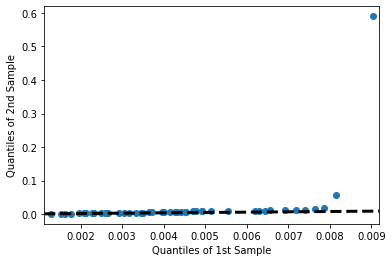

In [46]:
for col in ["offered_interest_rate", "credit_score", "loan_amnt", "dti", "pti"]:
    qqplot_2samples(raleigh_table[raleigh_table.offer_accepted == True][col], lubbock_table[lubbock_table.offer_accepted == True][col])
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
    plt.show()

So it seems that there are some differences between the two populations. Let's visualizes this using a KDE (kernel density estimation) smoothening. This is implemented (with Gaussian kernel), for example, in the [`seaborn.distplot`](https://seaborn.pydata.org/generated/seaborn.histplot.html) package, using the `kde=True` flag. Use this package to compare the distributions of `credit_score` and `int_rate` in the activated populations in Raleigh and Luboock. What do you observe?

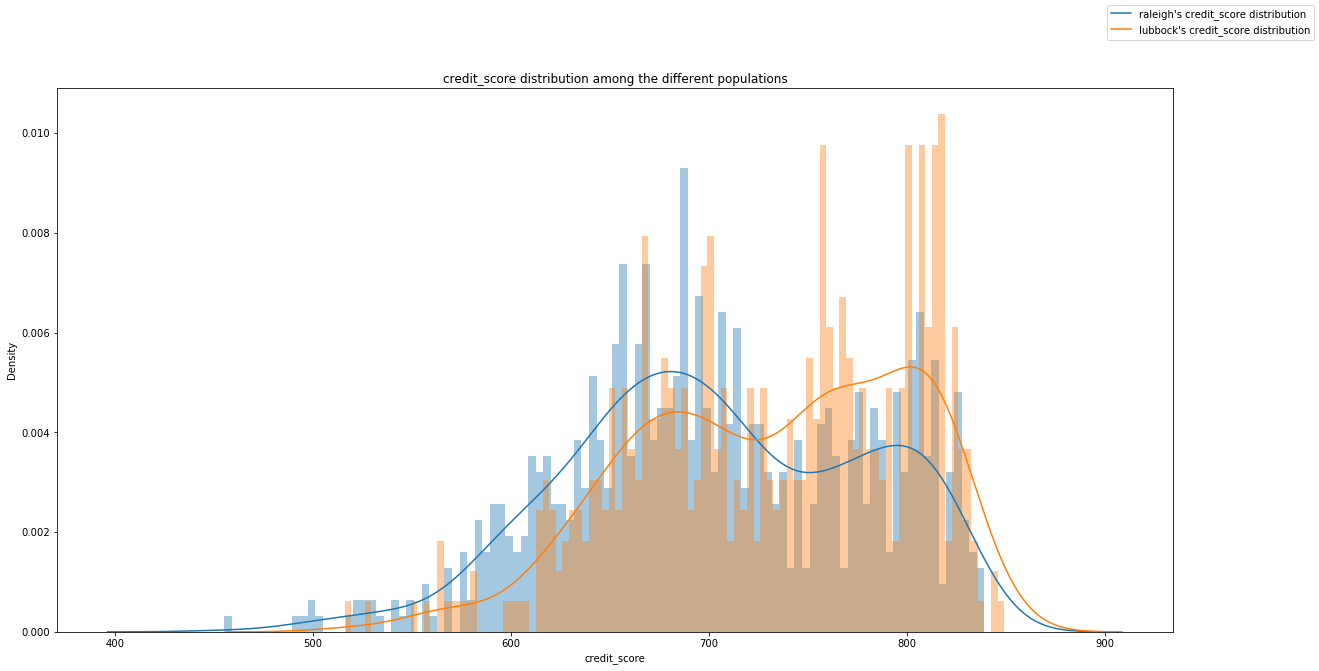

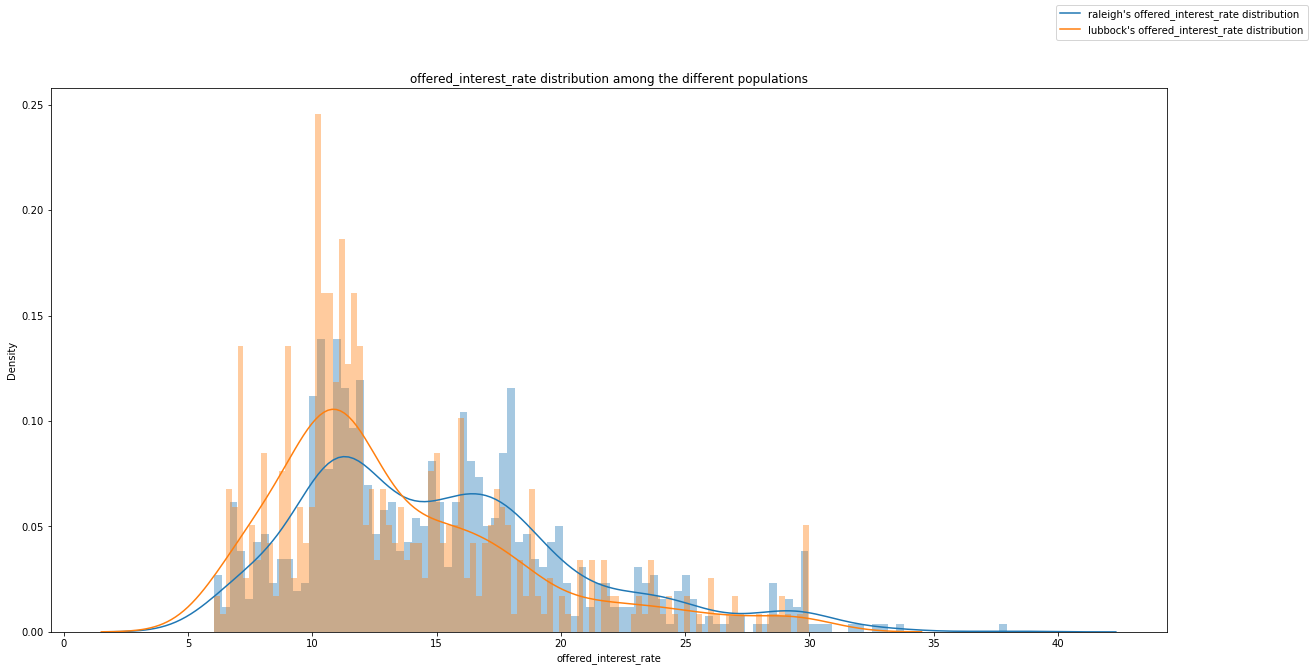

In [50]:
fig = plt.figure(figsize=(20,10))

sns.distplot(raleigh_table[raleigh_table.offer_accepted == True].credit_score, bins = 100, kde = True)
sns.distplot(lubbock_table[lubbock_table.offer_accepted == True].credit_score, bins = 100, kde = True)

fig.legend(labels=["raleigh's credit_score distribution","lubbock's credit_score distribution"])
plt.title("credit_score distribution among the different populations")
plt.show();

fig = plt.figure(figsize=(20,10))

sns.distplot(raleigh_table[raleigh_table.offer_accepted == True].offered_interest_rate, bins = 100, kde = True)
sns.distplot(lubbock_table[lubbock_table.offer_accepted == True].offered_interest_rate, bins = 100, kde = True)

fig.legend(labels=["raleigh's offered_interest_rate distribution","lubbock's offered_interest_rate distribution"])
plt.title("offered_interest_rate distribution among the different populations")
plt.show();

## Checking goodness of fit of the two distributions 

The question of whether the two activated populations are drawn from the same borrower population can also be tested using the Kolmogorov-Smirnov test. Setting your confidence level at 5%, and using the [scipy.stats.ks_2samp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html) package, formulate and perform a two-sample Kolmogorov-Smirnov test to check if the activated populations in Raleigh and Lubbock differ in terms of credit score.

In [51]:
stats.ks_2samp(raleigh_table[raleigh_table.offer_accepted == True].credit_score, lubbock_table[lubbock_table.offer_accepted == True].credit_score)


KstestResult(statistic=0.1843668501883512, pvalue=1.3599933401664543e-09)

<span style="color:teal">The null hypothesis of a two-sided KS test is that the two samples are drawn from the same distribution. Since our p-value is very small, we are able to say that the distribution of credit scores in raleigh and lubbock are different. </span>

## Soft clustering for detecting risk sub-populations

As you may have noted, for both credit score and interest rate, the distribution of values in Raleigh and Lubbock goes from being unimodal, for the general population, to bimodal, for the activated population. This is a commonly observed phenomenon and there are many speculations about why this happens. One possibility, is that the distribution of values in the activated population is in fact a mixture of two distinct borrower populations (e.g. risky and non-risky).

In this section we will use a Gaussian [mixture-model](https://en.wikipedia.org/wiki/Mixture_model) (GMM), which is a soft clustering model, in order to try to detect the existence of two borrower populations in among activated loans.

_Remark_: While credit score and offered interest rate are generally fair indicators of the risk of a loan, using them as markers for the risk of a loan is very simplistic and should not be done beyond exploratory analyses.

In fit to apply a mixture model to our data, we will use the [`sklearn.mixture.GaussianMixture`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) package. Import this package.

In [68]:
from sklearn.mixture import GaussianMixture

Do the following:
* Initiate an instance of `GaussianMixture`
* Create the training dataset, which comprises of two columns of all credit scores and interest rates of **activated loans** in Lubbock **and** Raleigh, each row corresponding to a single loan
* fit your `GaussianMixture` instance to this data to detect a 2-component mixture

Refer to the packages [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) if you run into any trouble.

In [96]:
gm = GaussianMixture(n_components=2, random_state = 42)
df1 = raleigh_table[raleigh_table.offer_accepted == True][["credit_score","offered_interest_rate"]]
df2 = lubbock_table[lubbock_table.offer_accepted == True][["credit_score","offered_interest_rate"]]
df = pd.concat([df1,df2])
df = df.dropna(axis=0)
gm.fit(df)
print(gm.means_)
#gm.get_params(deep=True)

[[745.40792113  11.75523794]
 [646.64095475  20.56399451]]


Look at the center points of the two distributions you detected (using the packages `means_` attribute). Do the means of the distribution corroborate the hypothesis that the population correspond to different risk groups? (recall- higher risk borrowers tend to have lower credit scores and be offered higher interest rates).

<span style="color:teal">The second cluster has heigher mean credit score and is offered (generally) lower interest rates. We can assume for the moment that it corresponds to a lower risk groups. </span>

Use your `GaussianMixture` instance to classify the activated population in Raleigh into two joint credit score-interest rate distributions. Create a scatter plot describing the credit score and interest rate of **all** loan offers in Raleigh, in which non-activated loans are colored  in one color, and the point representing activated loans are colored according to the distribution they are drawn from.

_Remark_: Since this plot would have a very large number of points, it might be a good idea to play with the values of `alpha` and `s`, so that the different groups would be more apparent.

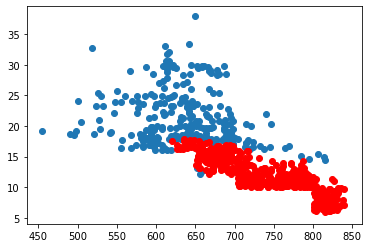

In [116]:
vec = gm.predict(df1)
a = df1[vec==1]
b = df1[vec==0]
c = 
plt.scatter(a.credit_score, a.offered_interest_rate)
plt.scatter(b.credit_score, b.offered_interest_rate, c = 'r')


Create the same scatterplot for the Lubbock table. Can you detect any differences between the two plots visually?

\* **Bonus** Create a function that adds some of the level sets of the underlying Gaussian distiburions to the scatterplots above. Recreate the scatter plots with level sets at 1,2,3 and 4 standard deviations from the mean.

# Infrernce from a regression model

So far, our analysis of risk groups has been exploratory and did not include any computation of return or actual assesment of the risk of a group. Also, our partition of the data into two risk groups was partially based on credit scores, which are imperfect predictors of the risk of a loan. 

In this section, we will attempt a more analytic approach to classifying risk populations. Before starting our analysis, we should decide on a criterion for a sub-population to be riskier than another. Throughout this section, we will use the sub-population's portfolio's yield as this criterion; that is- we'll consider one sub-population as riskier than another if the former's portfolio has a significantly lower yield than the latter.

## Comparing high-risk and low-risk subgroups

To begin with, we need to decide on our classification of high-risk and low-risk subgroups. In the previous section we relied on the borrowers' credit scores and offered interest rates for clasifying these subgroups; however, these metrics have some obvious problems. For example, many borrowers have no credit scores, and could not be classified using it. Also, interest rate not a direct assessment of the risk level of the client, but rather a reflection of the risk assessed by the issuing company.

Instead, we'll attempt to use an internally developed charge-off (CO) classifier, called the `PPCC21 model`. This model is a machine learning model, which attempts to predict whether a given loan is likely to default (or, synonymously- charge off). Since a charge-off event has a very negative effect on the yield of a portfolio, we will consider the predicted CO population as the high-risk group and non-CO population as the low-risk population. However, this statement is not clear-cut and needs to be tested.

### Analyzing historic payments data

In this section, we will test our hypothesis that CO populations are significantly riskier (and therefore produce significantly lower yields) than no-CO population. In order to do so, we will need complete payments data from historic loans. Let's start by uploading our data. 

In the following path, you will find payment records on ~470,000 loans from 2017Q2.

In [66]:
payments2017Q2=pd.read_parquet(os.path.join(ASSIGNMENT2_DATA,"TU_agg_payments.parquet")) 

The payments table contains aggregated payments; that is- the column `agg_paid{i}` contains the amount paid by the client up to the i-th month on book (MOB). Add new columns to the table (one for each mob), containing the amount paid by the client _at_ mob i.

Compute the [internal revenue rate (IRR)](https://www.investopedia.com/terms/i/irr.asp) of each loan. Use the [`numpy_financial.irr`](https://numpy.org/numpy-financial/latest/irr.html) function.

In [70]:
import numpy_financial as npf

Are there any nan values in your irr column? Investigate these and decide how to handle them.

<span style="color:teal">Oh no! There are nans in the irr column! If we look at these lines, we'll see that these happens when no payments were made _at all_! We'll fill these nans with -1, since these mean that the loan is a loss of a 100%.
</span>

### Running a model

Import the PPCC21 model:

In [ ]:
from pagayapro.models.PPCC21Model import PPCC21Model

The model comes trained out-of-the-box (on a set of ~160,000 loans from 2016), and has two attributes:
* `predict` - which returns T/F predictions on whether or not a loan is predicted to charge-off (True $
\iff$ loan will CO); and
* `predict_proba` - which return the predicted probability of each loan to CO and to not CO.

(it also has a `fit` attribute which we will not use). 

Both `predict` and `predict_proba` are able to predict on any dataframe with suitable features, regardless of their order or other columns in the df.

Create an instance of your model

In order to predict whether a loan will CO or not, you will also need to add TU feature for you loans. To do so, read the 2017Q2 feature file (path below) and merge it with the payments table, to create an enriched payments table. _Note_: the merge operation may take a while. Feel free to try to improve it.

In [78]:
features2017Q2= pd.read_parquet(os.path.join(ASSIGNMENT2_DATA,"TU2017Q2_features.parquet"))

Use the model to get a prediction for each row of your `enriched_features` dataframe.

### Some model validations

Let us validate the model's accuracy. What percentage of loans in the `enriched_payments` data are charged-off? (note: a loan is COed iff it has a reported CO-mob).

What percentage of loans are predicted to be COed by the model?

Use the `sklearn.metrics.accuracy_score` to get the models accuracy score.

As you see, there is room for improvement in the model's ability to predict CO. However, there is reason to believe that it might be useful for more general risk prediction, which we will try to verify here. In what follows, we call the group the model predicted as CO by predicted-CO, and the second group by predicted-non-CO. Our criterion for the risk of a group would be a significant difference in average IRR for this group.

### Visualizing IRR

Create a scatter plot depicting the IRR of a given loan vs its interest rate, and color each group (predicted-CO and predicted-non-CO) with a different color. What phenomena can you detect from the scatterplot? 

_Note_. The IRR is given in monthly terms, while interest rate is usually given in annual term. The standard formula for passing from a mothly rate to an anuual term is
$$\text{annual rate}=\left(1+\text{monthly rate}\right)^{12}-1.$$
A very common approximation is to simply multiply the monthly rate by 12.

<span style="color:teal">Predicted CO points seem to cluster towards higher interest rates. As the irr decreases, the proportion of CO seems to incread, where the bottom line (yield = -1) is nearly all orange.

Line formation is also interesting- why?
</span>

What is the average IRR for the predicted-CO goup? what is the average IRR for the predicted-non-CO group?

_Remark_. The average IRR is usually not the best estimator for the IRR of a portfolio, as it can be very different from the total IRR. However, considering averages allows us to apply statistical tool, which gives way for analyses; specifically, using linear regression.

_Another remark_. A beter approximation for the IRR of a portfolio can be achieved using a weighted average instead of an ordinary average (e.g. weigheted by the loan's amount). Feel free to try to adapt the current method for weighted averages.

## Statistical test for comparing averages

As explained in the notion page, the averages of two population of a sample can be compared using infrernce from a linear regression model. Indeed, the averages of the two subsets are different if and only if the slope of the regression line $y\sim mx+n$, where $x=1$ on one subset and $0$ otherwise, is non-zero.

Use the [statsmodels.api.OLS](https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html) package in order to create a regression model, with IRR as the dependent variable and a binary variable describing membership to either of the CO-groups as the independent variable. 

Create a sctterplot of the dependent vs the independent variable of the model, and add the regression line to the plot. In addition, it is recommended that yoy add lines indicating the confidence region of your regression line (you can use the [seaborn.regplot](https://seaborn.pydata.org/generated/seaborn.regplot.html) package or some of the additional functionality of `statsmodels.api.OLS` package).

Is the slope of the regression line significantly different from zero? What can you conclude from this result regarding the difference in risk levels between the two groups?

<span style="color:teal">
The two means are different to a very high degree of significance. However, the confidence interval is very wide, indicating a large margin of error, and the actual difference between the means is very small (under 0.3%), so it is unclear whether there is a good enough separation between the groups.
</span>

### Controlling for interest rate

To check whether the difference in risk between the two groups is explained by the different interest rate, fit a new regression model, now with both model score and interest rate as covariates, and check whether the risk level is different between the two groups when controlling for interest rate.

Create two overlaying scatterplots of IRR vs interest rate, according to the different groups, and add the regression line associated to each group the the corresponding scatterplot. Can you detect a visible difference between the two groups?

<span style="color:teal">
    Some difference, but very slight
    </span>

Check the model's results summary to see if the coefficient related to model-score group is significantly different from zero.

What is your conclusion? Is the risk level between the two groups different when interest rate is controlled for?

Can you rely on the PPCC21 model score as an indicator for risk level?

<span style="color:teal">
        The model significantly separates between the two risk groups, but the separation seems to be ineffective
</span>

## Comparing proportions of the different groups in Raleigh and Lubbock

In order to compare the risk levels of the activated populations in Raleigh and Lubbock, start by adding a model prediction to each activated loan of the two tables. You have already added the necessary TU feature to the tables in a previous section, so all that's left is to run the model on each of them get the necessary predictions, and add these as a column to the table.

Run a proprotions test in order to check if the proportion of risky borrowers is significantly larger in Raleigh than in Lubbock.

What do you conclude regarding the risk level of the activated population in each town?

<span style="color:teal"> 
    We cannot reject the null hypothesis that the proportion of risky borrowers in Raleigh is smaller or equal to the one in Lubbock.
    </span>

# Analysis using current payments

One more strategy for analyzing the risk level of a current portfolio is to analyze the number of late payments in a given period. Generally speaking, since loans with late or partial payments are indicative of the borrower's ability to repay the loan, we consider portfolios with higher proportions of such payments as being riskier.

We'll call a loan late at mob i if its payment at this month is less then 95% of the amount that was supposed to be paid on that month.

We have payments reports for the first six months of each loan issued before 2020 in Raleigh and Lubbock. These are available in the following directories:

In [142]:
raleigh_current_pmts= pd.read_parquet(os.path.join(ASSIGNMENT2_DATA, "payment_report_RL.parquet"))
lubbock_current_pmts= pd.read_parquet(os.path.join(ASSIGNMENT2_DATA, "payment_report_LB.parquet"))

The payments file come in the form of tradelines; that is- each row describe a single payment made towards a give loan,

Create new tables in which every loan id appears in a unique line, along with its features (`int_rate`, `loan_amnt`, `monthly_pmt` etc), and there is a column `pmt_{i}` for each `i`=1,..,6 which contains the payment made at mob `i`. Use the [pandas.DataFrame.pivot](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html) method in order to perform the last part.

Add a column to the dataframes above, containing the number of late months of the corresponding loan (that is- the number of months in which the amount paid is less then 95% of the monthly payment.

For each number n=0,..,6 compute the percentage of loans each of the above table that are late by n months. Plot these distributions (e.g. using the [seaborn.countplot](https://seaborn.pydata.org/generated/seaborn.countplot.html) function). Can you detect a visible difference between the two tables?

So we've seen by now that there is a detectable difference between the frequencies of late payments in the two towns, but how do the two of them compare with the general population?

In order to get a benchmark for the number of late payments at each mob in the general population, we'll also draw payment reports from the general population. To this end, you will find payments reports for the period 2017-04--2020-12, taken from the Upgrade platform, in the following path:

In [ ]:
upgrade_payments = pd.read_parquet(os.path.join(ASSIGNMENT2_DATA, "upgrade2020_payments.parquet"))

Note that these files are also formatted as tradelines, with the amount paid at each month recorded in the column `paid`, and should be reformatted so that all payments of a given loan appear in a single line using the `pandas.DataFrame.pivot` method. Do this now- create a new table in which every loan appears in a single line, with a column for each mob containing the amount paid at that mob.
Additionally, add the following features of the loan: `loan_amnt`,`original_interest_rate`, `term_in_months` and `last_reported_mob`.

As you may have noted, the monthly payment of each loan is missing from the table above. Please compute it using the [numpy_financial.pmt](https://numpy.org/numpy-financial/dev/pmt.html) function.

Now, repeat the analysis you done above in order to compute the percentages of late loans by month in the general population and compare them to your results from Raleigh and Luboock. Which of the two seem closer to the population banchmark?

Perform a statistical test which will validate this observation. That is- compare the proportion of loans late by n months in each of the towns with that of the general population and test which of these are significantly different from the general population. Note that you are comparing 6 subsets of the same sample, so this may require some manipulation of your alpha values.